# Fine Tuning of LLM for translation task - From Natural Language (NL) to First Order Logic Language (FOL)

In [ ]:
!pip install transformers datasets torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl

In [ ]:
from transformers import AutoTokenizer, BartForConditionalGeneration, DataCollatorForSeq2Seq, Trainer, TrainingArguments
from datasets import load_dataset
import torch
import math

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**BART MODEL** \
BART (Bidirectional and Auto-Regressive Transformers) is a powerful sequence-to-sequence model designed by Facebook AI Research (FAIR). It combines the strengths of bidirectional and autoregressive transformers, making it highly effective for a range of text generation tasks, including translation, summarization, and text generation.

Key Features of BART:\
**Bidirectional Encoder:** BART uses a bidirectional encoder, similar to BERT, which allows it to understand the entire context of a sentence by looking at both past and future tokens. \
**Autoregressive Decoder:** The decoder is autoregressive, similar to GPT, which means it generates text one token at a time, using previously generated tokens as context. \
**Denoising Autoencoder:** BART is trained as a denoising autoencoder, which involves corrupting text with noise and training the model to reconstruct the original text. This pretraining strategy makes BART robust and capable of understanding complex text structures.

Why BART is a Good Choice for Translation from Natural Language (NL) to First-Order Logic (FOL)? \

Sequence-to-Sequence Framework: \
Translating NL to FOL is a sequence-to-sequence task where an input sequence (NL) needs to be transformed into an output sequence (FOL). BART is designed specifically for such tasks, making it an appropriate model choice.\

Contextual Understanding:\
The bidirectional encoder of BART allows it to grasp the full context of the NL input, which is crucial for accurately interpreting the semantics of natural language sentences and converting them into logical formulas.

In [ ]:
# Use the BART model
model_name = "facebook/bart-base"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

In [ ]:
dataset = load_dataset("yuan-yang/MALLS-v0")

# Use 10% of the training data as validation data
train_data = dataset['train'].train_test_split(test_size=0.1)
val_data = train_data['test']
train_data = train_data['train']

# Preprocess the data: Tokenize the inputs and outputs
def preprocess_function(examples):
    inputs = examples['NL']
    targets = examples['FOL']
    model_inputs = tokenizer(inputs, padding="max_length", truncation=True, max_length=64)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, padding="max_length", truncation=True, max_length=64)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

train_data = train_data.map(preprocess_function, batched=True)
val_data = val_data.map(preprocess_function, batched=True)
test_data = dataset['test'].map(preprocess_function, batched=True)

Generating train split:   0%|          | 0/27284 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/24555 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4016: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/2729 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=3,  # Adjust based on your GPU memory
    per_device_eval_batch_size=3,   # Adjust based on your GPU memory
    num_train_epochs=6,
    weight_decay=0.01,
    fp16=True,                      # Enable mixed precision training
    gradient_accumulation_steps=8,  # Adjust based on batch size
    logging_dir='./logs',
    save_total_limit=2,             # Limit the total amount of checkpoints
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    data_collator=data_collator,
    tokenizer=tokenizer
)

import torch
torch.cuda.empty_cache()

# Train the model
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
0,0.270100,0.182357
1,0.186800,0.158235
2,0.147800,0.147807
3,0.123500,0.143633
4,0.106000,0.141108
5,0.095200,0.140843


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file

TrainOutput(global_step=6138, training_loss=0.1987466538678788, metrics={'train_runtime': 2971.2777, 'train_samples_per_second': 49.585, 'train_steps_per_second': 2.066, 'total_flos': 5613843571015680.0, 'train_loss': 0.1987466538678788, 'epoch': 5.99926695174099})

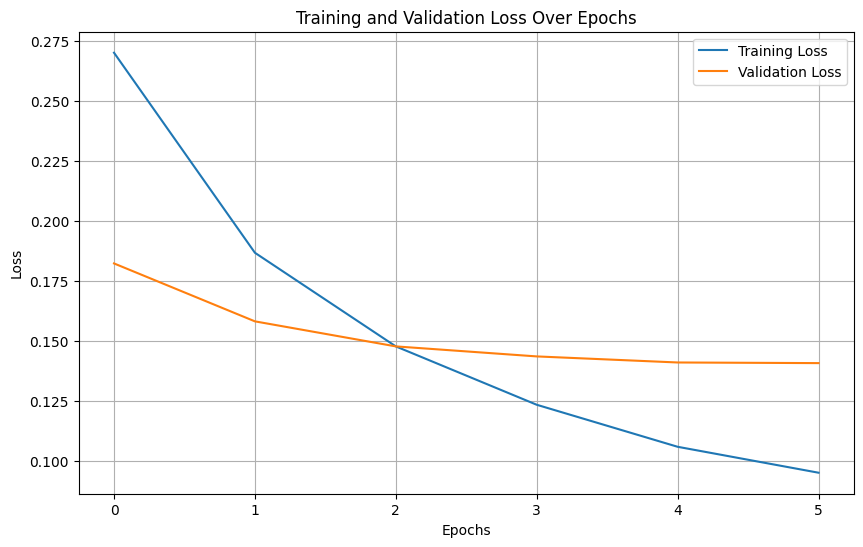

In [ ]:
import matplotlib.pyplot as plt

# Data from the table
epochs = [0, 1, 2, 3, 4, 5]
training_loss = [0.270100, 0.186800, 0.147800, 0.123500, 0.106000, 0.095200]
validation_loss = [0.182357, 0.158235, 0.147807, 0.143633, 0.141108, 0.140843]

# Plotting the values
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
for i in range(5):
    nl_example = dataset['train'][i]['NL']
    fol_example = dataset['train'][i]['FOL']
    print(f"NL: {nl_example}")
    print(f"FOL: {fol_example}")
    print()

NL: A film can be a drama, have a long runtime, and win multiple awards, or it can be a comedy, have a shorter runtime, and be a box office success.
FOL: ∃x (Film(x) ∧ ((Drama(x) ∧ LongRuntime(x) ∧ MultipleAwards(x)) ∨ (Comedy(x) ∧ ShorterRuntime(x) ∧ BoxOfficeSuccess(x))))

NL: If a person is a librarian, they either work in a public library or an academic library.
FOL: ∀x (Person(x) ∧ Librarian(x) → WorkInPublicLibrary(x) ⊕ WorkInAcademicLibrary(x))

NL: Healthy sleep habits improve overall well-being.
FOL: ∀x (HealthySleepHabits(x) → ImprovesWellBeing(x))

NL: A shape can have three or four sides, but not both.
FOL: ∀x (Shape(x) → (ThreeSides(x) ⊕ FourSides(x)))

NL: Water boils at 100 degrees Celsius at sea level.
FOL: BoilsAtTemperature(water, 100, seaLevel)



Perplexity is a commonly used metric in language modeling and measures how well a probability model predicts a sample. In the context of language models, perplexity provides a quantitative measure of how well the model is predicting the next word in a sequence.

In [ ]:
# Evaluate the model
eval_results = trainer.evaluate()

# Calculate and print the perplexity
import math
perplexity = math.exp(eval_results["eval_loss"])
print(f"Perplexity: {perplexity}")

def translate_nl_to_fol(nl_statement):
    inputs = tokenizer(nl_statement, return_tensors="pt", padding=True).input_ids.to(model.device)
    attention_mask = tokenizer(nl_statement, return_tensors="pt", padding=True).attention_mask.to(model.device)
    outputs = model.generate(inputs, attention_mask=attention_mask, max_length=50)
    fol_formula = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return fol_formula

# Example usage
nl_statement = "Every human is mortal."
fol_formula = translate_nl_to_fol(nl_statement)
print(f"FOL formula: {fol_formula}")

Perplexity: 1.15124332698587
FOL formula: ∀x (Human(x) → Mortal(x))


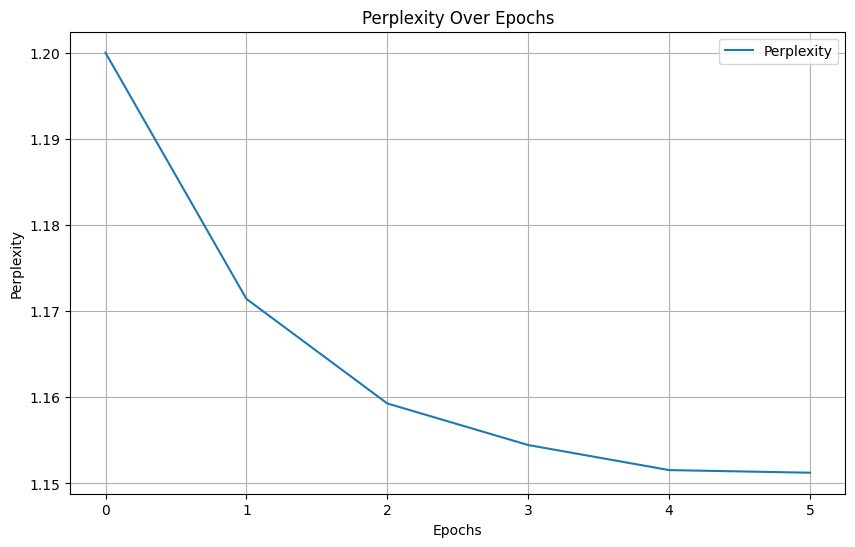

Epoch 0: Perplexity = 1.2000425326009958
Epoch 1: Perplexity = 1.1714414511047857
Epoch 2: Perplexity = 1.1592891319679346
Epoch 3: Perplexity = 1.1544603438226642
Epoch 4: Perplexity = 1.1515490085620768
Epoch 5: Perplexity = 1.151243888505001


In [ ]:
import math
perplexity1 = [math.exp(loss) for loss in validation_loss]

# Plotting Perplexity
plt.figure(figsize=(10, 6))
plt.plot(epochs, perplexity1, label='Perplexity')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.title('Perplexity Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Print perplexity values for reference
for epoch, perp in zip(epochs, perplexity1):
    print(f"Epoch {epoch}: Perplexity = {perp}")

Interpretation of Perplexity \
Lower Perplexity: Indicates that the model is better at predicting the next word in the sequence. Lower values signify a better language model.A perplexity of 1 means that the model predicts the next word with complete certainty\
Higher Perplexity: Indicates that the model is worse at predicting the next word in the sequence. Higher values signify a poorer language model.

In [ ]:
print(eval_results)

{'eval_loss': 0.1408425122499466, 'eval_runtime': 15.3354, 'eval_samples_per_second': 177.955, 'eval_steps_per_second': 59.34, 'epoch': 5.99926695174099}


In [ ]:
# Save the model and tokenizer to Google Drive
model.save_pretrained('/content/drive/MyDrive/trained_model')
tokenizer.save_pretrained('/content/drive/MyDrive/trained_model')

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


('/content/drive/MyDrive/trained_model/tokenizer_config.json',
 '/content/drive/MyDrive/trained_model/special_tokens_map.json',
 '/content/drive/MyDrive/trained_model/vocab.json',
 '/content/drive/MyDrive/trained_model/merges.txt',
 '/content/drive/MyDrive/trained_model/added_tokens.json',
 '/content/drive/MyDrive/trained_model/tokenizer.json')

In [ ]:
model.save_pretrained("./trained_model")
tokenizer.save_pretrained("./trained_model")

!zip -r trained_model.zip ./trained_model

from google.colab import files
files.download('trained_model.zip')

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


  adding: trained_model/ (stored 0%)
  adding: trained_model/tokenizer_config.json (deflated 75%)
  adding: trained_model/tokenizer.json (deflated 72%)
  adding: trained_model/generation_config.json (deflated 47%)
  adding: trained_model/merges.txt (deflated 53%)
  adding: trained_model/model.safetensors (deflated 8%)
  adding: trained_model/vocab.json (deflated 59%)
  adding: trained_model/config.json (deflated 64%)
  adding: trained_model/special_tokens_map.json (deflated 52%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>